In [195]:
"""Load packages"""

%pip install geopandas matplotlib contextily

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
from matplotlib import patches
from IPython.display import display
import numpy as np
import re
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import linregress


Note: you may need to restart the kernel to use updated packages.


In [2]:
"""Load data"""

# List of file names
files = [f"df{i}.csv" for i in range(1, 13)]
dfs = [pd.read_csv(file, sep=",", encoding="latin1") for file in files]

df = pd.concat(dfs, ignore_index=True)

print(df.shape)

(1537584, 25)


In [ ]:
"""Data preprocessing 1: drop cols, filter for PFAS, add cols for Year and Month, calculate relative contamination levels"""



# Drop cols
### Add code here later, the df is small enough to handle for now

# Filter data for PFAS contaminants
pfas_list = [
    "PFOA", "PFBS", "PFHpA", "PFHxS", "PFNA", "PFOS", "9Cl-PF3ONS", "NEtFOSAA",
    "PFTrDA", "ADONA", "PFTA", "NMeFOSAA", "PFHxA", "HFPO-DA", "PFPeS", "PFHpS",
    "PFDoA", "PFMPA", "11Cl-PF3OUdS", "PFDA", "PFEESA", "PFUnA", "PFBA", "PFPeA",
    "8:2 FTS", "NFDHA", "6:2 FTS", "4:2 FTS", "PFMBA"
]

df_PFAS = df[df["Contaminant"].isin(pfas_list)].copy()  


# Convert 'CollectionDate' to datetime, drop rows with missing datetime string
# Add cols for Year and Month 
df_PFAS["CollectionDate"] = pd.to_datetime(df_PFAS["CollectionDate"], errors='coerce')
df_PFAS = df_PFAS.dropna(subset=["CollectionDate"]) 

df_PFAS["Year"] = df_PFAS["CollectionDate"].dt.year
df_PFAS["Month"] = df_PFAS["CollectionDate"].dt.month


# Add cols for MRL level exceeded: Count '<' and '=' occurrences and create seperate columns, add a col for count of both (total)
df_PFAS.loc[:, 'Count_Less_Than'] = (df_PFAS['AnalyticalResultsSign'] == '<').astype(int)
df_PFAS.loc[:, 'Count_Equals'] = (df_PFAS['AnalyticalResultsSign'] == '=').astype(int)
df_PFAS.loc[:, "Total_Values"] = df_PFAS["Count_Less_Than"] + df_PFAS["Count_Equals"]

# Add a column for proportion of contaminated samples
df_PFAS['Equals_Per_Total'] = df_PFAS['Count_Equals'] / df_PFAS['Total_Values']


# Add col for Relative Contamination level (delta AnalyticalResultValue / MRL); only for values with AnalyticalResultsSign "="
# This divides the measured value for samples exceeding the threshold MRL, by the MRL value
# Result is a measure how much the MRL is exceeded
df_PFAS.loc[df_PFAS["AnalyticalResultsSign"] == "=", "Relative_Contamination_Level"] = (
    df_PFAS["AnalyticalResultValue"] / df_PFAS["MRL"]
)


print("\n📌 Processed data -- General Info:")
df_PFAS.info()  

display(df_PFAS)



📌 Processed data -- General Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1537584 entries, 10 to 3363694
Data columns (total 31 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   PWSID                         1537584 non-null  object        
 1   PWSName                       1537584 non-null  object        
 2   Size                          1537584 non-null  object        
 3   FacilityID                    1537526 non-null  object        
 4   FacilityName                  1537555 non-null  object        
 5   FacilityWaterType             1537584 non-null  object        
 6   SamplePointID                 1537584 non-null  object        
 7   SamplePointName               1537584 non-null  object        
 8   SamplePointType               1537584 non-null  object        
 9   AssociatedFacilityID          221831 non-null   float64       
 10  AssociatedSamplePointID       22183

,PWSID,PWSName,Size,FacilityID,FacilityName,FacilityWaterType,SamplePointID,SamplePointName,SamplePointType,AssociatedFacilityID,...,Region,State,UCMR1SampleType,Year,Month,Count_Less_Than,Count_Equals,Total_Values,Equals_Per_Total,Relative_Contamination_Level
10,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
11,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
12,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
13,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
14,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363690,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN
3363691,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN
3363692,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN
3363693,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN


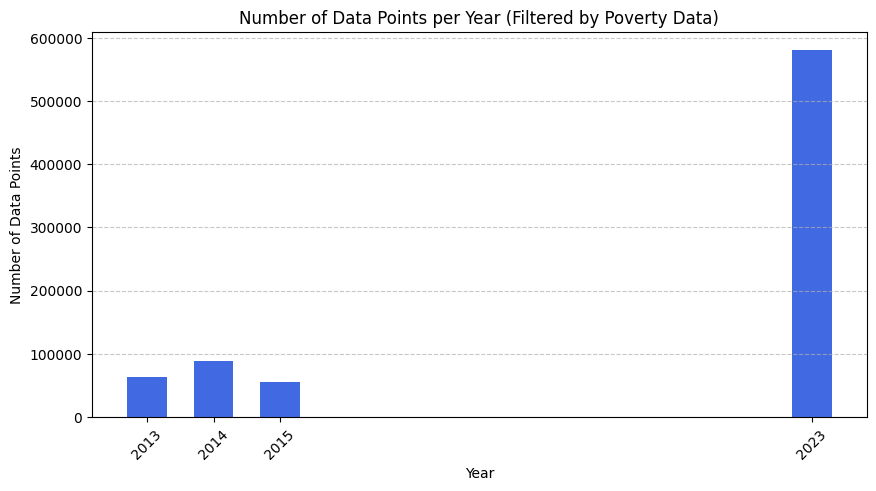

In [7]:
# Explore poverty data

import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace this with your actual df_PFAS)
data = df

df_PFAS = pd.DataFrame(data)

# ✅ Step 1: Filter out rows where any poverty data is NaN
df_filtered = df_PFAS.dropna(subset=["Median_Income","Poverty_Rate"])

# ✅ Step 2: Group by Year and count rows
yearly_counts = df_filtered.groupby("Year").size()

# ✅ Step 3: Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(yearly_counts.index, yearly_counts.values, width=0.6, color='royalblue')

# Formatting
plt.xlabel("Year")
plt.ylabel("Number of Data Points")
plt.title("Number of Data Points per Year (Filtered by Poverty Data)")
plt.xticks(yearly_counts.index, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

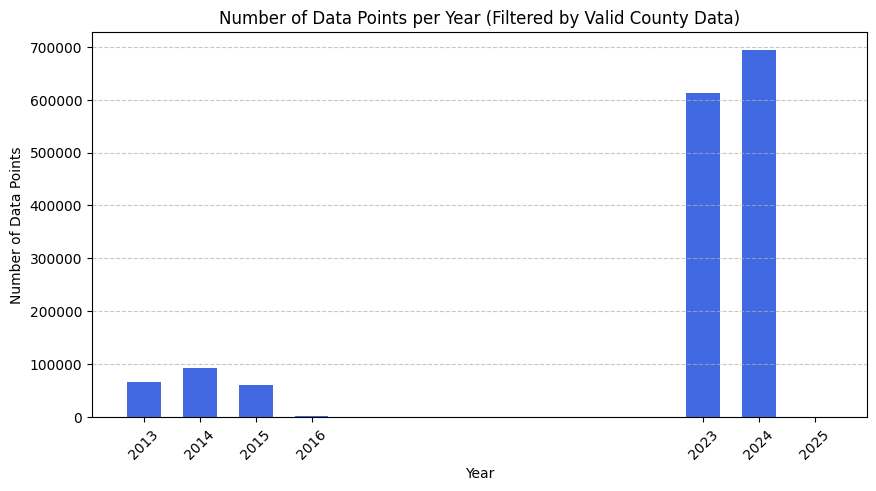

In [8]:
# Explore county data


import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace with actual df_PFAS)
data = df

df_PFAS = pd.DataFrame(data)

# ✅ Step 1: Filter out rows where 'County' is empty or 'Not Found'
df_filtered = df_PFAS[~df_PFAS["County"].isin(["", "Not Found"])]

# ✅ Step 2: Group by Year and count rows
yearly_counts = df_filtered.groupby("Year").size()

# ✅ Step 3: Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(yearly_counts.index, yearly_counts.values, width=0.6, color='royalblue')

# Formatting
plt.xlabel("Year")
plt.ylabel("Number of Data Points")
plt.title("Number of Data Points per Year (Filtered by Valid County Data)")
plt.xticks(yearly_counts.index, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


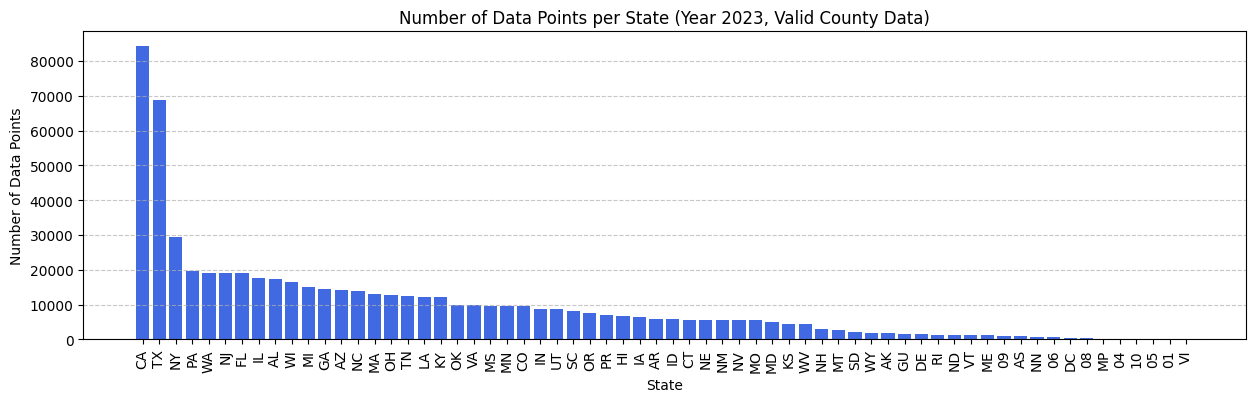

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace with actual df_PFAS)
data = df

df_PFAS = pd.DataFrame(data)

# ✅ Step 1: Filter for Year 2023 and remove invalid County entries
df_2023 = df_PFAS[(df_PFAS["Year"] == 2023) & (~df_PFAS["County"].isin(["", "Not Found"]))]

# ✅ Step 2: Count number of rows per state
state_counts = df_2023["State"].value_counts()

# ✅ Step 3: Plot bar chart
plt.figure(figsize=(15, 4))
plt.bar(state_counts.index, state_counts.values, color='royalblue')

# Formatting
plt.xlabel("State")
plt.ylabel("Number of Data Points")
plt.title("Number of Data Points per State (Year 2023, Valid County Data)")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [271]:
"""Data preprocessing: Create seperate data frames for 2023, and for Aggregation per state (incl coordinates)"""



df["CollectionDate"] = pd.to_datetime(df["CollectionDate"], errors='coerce')

df.loc[:, "Total_Values"] = df_PFAS["Count_Less_Than"] + df_PFAS["Count_Equals"]


# Create seperate file for 2023 data only
df_2024 = df[df["CollectionDate"].dt.year == 2023].copy()


# Aggregate data per state
df_states = df_2024.groupby("State").agg(
    Total_Values=('Total_Values', 'sum'),
    Count_Less_Than=('Count_Less_Than', 'sum'),
    Count_Equals=('Count_Equals', 'sum'),
    Max_Relative_Contamination=('Relative_Contamination_Level', 'max'),
    Median_Income = ('Median_Income', 'max'),
    Poverty_Rate = ('Poverty_Rate', 'max')
).reset_index()

# Compute Mean_Relative_Contamination where Count_Equals == 1
df_mean = df_2024[df_2024["Count_Equals"] == 1].groupby("State")["Relative_Contamination_Level"].mean().reset_index()
df_mean.rename(columns={"Relative_Contamination_Level": "Mean_Relative_Contamination"}, inplace=True)


# Merge back the Mean_Relative_Contamination values
df_states = df_states.merge(df_mean, on="State", how="left")
df_states["Mean_Relative_Contamination"].fillna(0, inplace=True)

# Remove non-state territories (i.e. numbers instead of states in state col)
df_states = df_states.iloc[8:].reset_index(drop=True)

# Add col for contaminated samples: "samples exceeding MRL" / "total samples"
df_states["Equals_Per_Total"] = df_states["Count_Equals"] / df_states["Total_Values"] *100
df_states.insert(4, "Equals_Per_Total", df_states.pop("Equals_Per_Total"))





"""Add (lognitudinal, latiduninal) coordinates to states data frame"""
# US territories and DC are ignored

# Scrape state coordinates
url = "https://www.latlong.net/category/states-236-14.html"
tables = pd.read_html(url)  # Reads all tables on the page
df_coords = tables[0]  # The first table contains the data
df_coords.columns = ["State_long", "Latitude", "Longitude"]  # Rename columns

# Clean up state names: Remove variations like ", usa", "the us", etc.
df_coords["State_long"] = df_coords["State_long"].str.lower().str.strip()
df_coords["State_long"] = df_coords["State_long"].apply(lambda x: re.sub(r",? (the )?us(a)?$", "", x))



# Create a Reference DataFrame with state abbreviations to match with our data and add abbreviations to df_coords
state_abbreviations = pd.DataFrame({
    'State_long': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
              'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
              'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
              'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
              'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
    'State': ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                     'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                     'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                     'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                     'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
})

state_abbreviations["State_long"] = state_abbreviations["State_long"].str.strip().str.lower()
df_coords = pd.merge(df_coords, state_abbreviations, on="State_long", how="left")
df_coords.drop(columns=['State_long'], inplace=True)

# Add coordinates to our data frame df_states
if "Longitude" not in df_states.columns or "Latitude" not in df_states.columns:
    df_states = pd.merge(df_states, df_coords, on="State", how="left")

    # Move "Latitude" and "Longitude" to the second position (index 1)
    df_states.insert(1, "Latitude", df_states.pop("Latitude"))
    df_states.insert(2, "Longitude", df_states.pop("Longitude"))

display(df_states)

/var/folders/zn/2ym95l4n2131dptxjp4dk3fh0000gn/T/ipykernel_99115/1264604123.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_states["Mean_Relative_Contamination"].fillna(0, inplace=True)


,State,Latitude,Longitude,Total_Values,Count_Less_Than,Count_Equals,Equals_Per_Total,Max_Relative_Contamination,Median_Income,Poverty_Rate,Mean_Relative_Contamination
0,FL,27.994402,-81.760254,19054,17906,1148,6.024982,46.300000,106281.0,23.5,2.730229
1,GA,33.247875,-83.441162,14427,14095,332,2.301241,96.666667,136347.0,31.6,2.502520
2,HI,19.741755,-155.844437,6872,6870,2,0.029104,1.100000,102382.0,16.5,1.050000
3,IA,42.032974,-93.581543,6503,6424,79,1.214824,129.580000,92695.0,16.1,5.961224
4,ID,44.068203,-114.742043,5779,5747,32,0.553729,12.750000,90513.0,20.6,2.249479
5,IL,40.000000,-89.000000,17968,17735,233,1.296750,46.640000,114606.0,20.7,2.744657
6,IN,40.273502,-86.126976,8998,8919,79,0.877973,13.233333,121231.0,20.2,2.123650
7,KS,38.500000,-98.000000,4466,4415,51,1.141961,36.666667,103085.0,15.6,3.613987
8,KY,37.839333,-84.270020,12202,12067,135,1.106376,10.240000,120818.0,48.1,1.968519
9,LA,30.391830,-92.329102,12492,12421,71,0.568364,4.833333,89558.0,46.5,1.339249


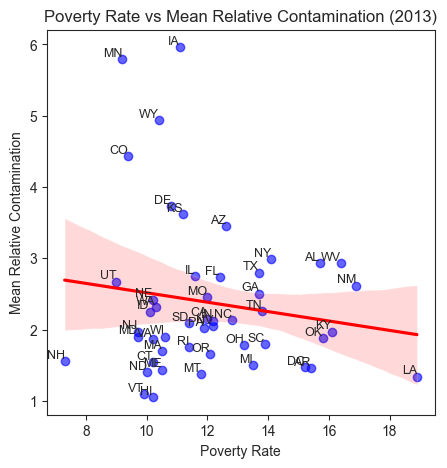

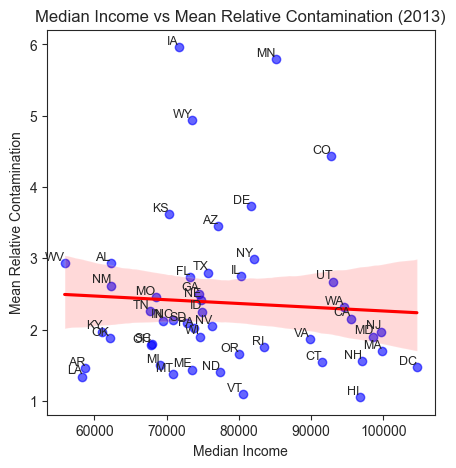

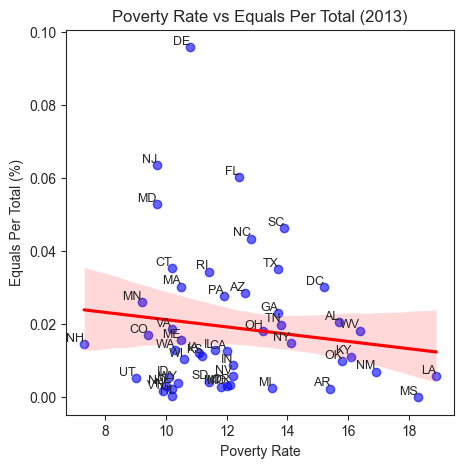

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

# Create scatter plot with regression line
sns.regplot(data=df_states, x="Poverty_Rate", y="Mean_Relative_Contamination", 
            scatter_kws={'color':'blue', 'alpha':0.6},  # Blue scatter points with transparency
            line_kws={'color':'red'})  # Red trend line

# Add labels for each state
for i, row in df_states.iterrows():
    plt.text(row["Poverty_Rate"], row["Mean_Relative_Contamination"],  
             row["State"], fontsize=9, ha="right", va="bottom")

# Labels & title
plt.xlabel("Poverty Rate")
plt.ylabel("Mean Relative Contamination")
plt.title("Poverty Rate vs Mean Relative Contamination (2014)")

plt.show()




plt.figure(figsize=(5, 5))

# Create scatter plot with regression line for Median_Income
sns.regplot(data=df_states, x="Median_Income", y="Mean_Relative_Contamination", 
            scatter_kws={'color':'blue', 'alpha':0.6},  # Blue scatter points with transparency
            line_kws={'color':'red'})  # Red trend line

# Add labels for each state
for i, row in df_states.iterrows():
    plt.text(row["Median_Income"], row["Mean_Relative_Contamination"],  
             row["State"], fontsize=9, ha="right", va="bottom")

# Labels & title
plt.xlabel("Median Income")
plt.ylabel("Mean Relative Contamination")
plt.title("Median Income vs Mean Relative Contamination (2014)")

plt.show()




plt.figure(figsize=(5, 5))

# Create scatter plot with regression line for Poverty Rate vs Equals_Per_Total
sns.regplot(data=df_states, x="Poverty_Rate", y="Equals_Per_Total", 
            scatter_kws={'color':'blue', 'alpha':0.6},  # Blue scatter points with transparency
            line_kws={'color':'red'})  # Red trend line

# Add labels for each state
for i, row in df_states.iterrows():
    plt.text(row["Poverty_Rate"], row["Equals_Per_Total"],  
             row["State"], fontsize=9, ha="right", va="bottom")

# Labels & title
plt.xlabel("Poverty Rate")
plt.ylabel("Equals Per Total (%)")
plt.title("Poverty Rate vs Equals Per Total (2014)")

plt.show()

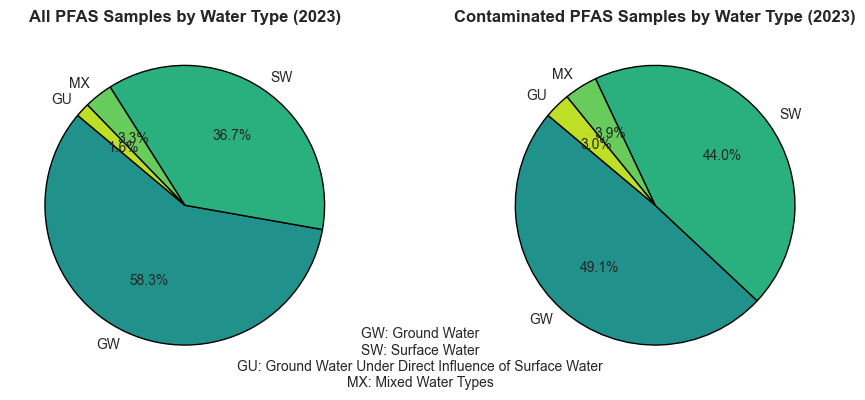

In [263]:
"""Visualization: Pie chart of sample water sources: all samples vs only contaminated samples (PFAS only, 2024, all states)"""

# Count occurrences of each FacilityWaterType (all values and confirmed contaminated)
water_type_counts = df_2023["FacilityWaterType"].value_counts()
water_type_confirmed = df_2023[df_2023["AnalyticalResultsSign"] == "="]["FacilityWaterType"].value_counts()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
viridis_cmap = sns.color_palette("viridis", as_cmap=True)

colors = [viridis_cmap(i) for i in np.linspace(0.5, 0.9, len(water_type_counts))]  # Sample from light range

# First Pie Chart - All samples
axes[0].pie(
    water_type_counts, 
    labels=water_type_counts.index,  
    autopct="%1.1f%%",
    colors=colors,
    startangle=140,
    wedgeprops={"edgecolor": "black"}
)
axes[0].set_title("All PFAS Samples by Water Type (2023)", fontsize=12, fontweight="bold")

# Second Pie Chart - Only Confirmed Contamination ( AnalyticalResultsSign = "=")
axes[1].pie(
    water_type_confirmed, 
    labels=water_type_confirmed.index,  
    autopct="%1.1f%%",
    colors=colors,  
    startangle=140,
    wedgeprops={"edgecolor": "black"}
)
axes[1].set_title("Contaminated PFAS Samples by Water Type (2023)", fontsize=12, fontweight="bold")

legend_text = """GW: Ground Water
SW: Surface Water
GU: Ground Water Under Direct Influence of Surface Water
MX: Mixed Water Types"""
fig.text(0.5, 0.02, legend_text, ha="center", fontsize=10)

plt.tight_layout()
plt.show()


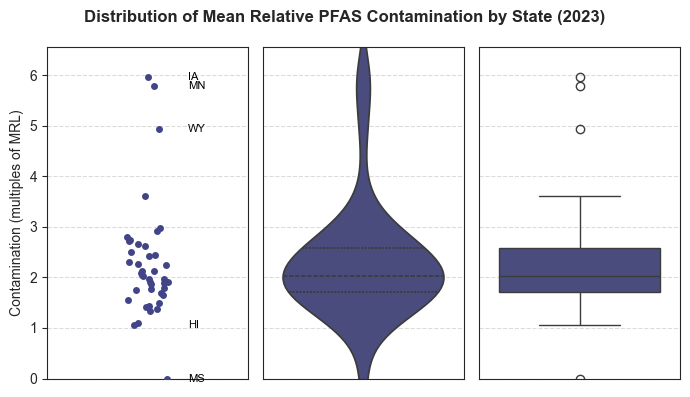

In [ ]:
"""Visualization: Strip, violin, bar plots of mean relative contamination (2023)"""

# Set general plot style
sns.set_style("ticks")

# Create a single-row, three-column figure layout
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

# Global y-axis limits
y_min = 0
y_max = df_states["Mean_Relative_Contamination"].max() * 1.1

dark_purple = "#440154"

# Identify top 3 and bottom 3 states by Mean Relative Contamination
top_3 = df_states.nlargest(3, "Mean_Relative_Contamination")
bottom_3 = df_states.nsmallest(2, "Mean_Relative_Contamination")
highlight_states = pd.concat([top_3, bottom_3])


# Strip plot for Mean Relative Contamination
main_color = sns.color_palette("viridis", as_cmap=True)(0.1)
sns.stripplot(y=df_states["Mean_Relative_Contamination"], ax=axes[0], jitter=True, color=main_color)

for i, row in highlight_states.iterrows():
    axes[0].text(0.2, row["Mean_Relative_Contamination"], row["State"],  # Shifted x-position
                 ha="left", va="center", fontsize=8, color="black")


axes[0].set_ylabel("Contamination (multiples of MRL)")

# Violin plot for Mean Relative Contamination
sns.violinplot(y=df_states["Mean_Relative_Contamination"], ax=axes[1], inner="quartile", color=main_color)
axes[1].set_ylabel("")
axes[1].set_yticklabels([])  
axes[1].tick_params(left=False)  

# Box plot for Mean Relative Contamination
sns.boxplot(y=df_states["Mean_Relative_Contamination"], ax=axes[2], color=main_color)
axes[2].set_ylabel("")
axes[2].set_yticklabels([])  
axes[2].tick_params(left=False)  

# Set same y-axis range for all subplots and add horizontal gridlines
for ax in axes:
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_ylim(y_min, y_max)  
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)  

fig.suptitle("Distribution of Mean Relative PFAS Contamination by State (2023)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

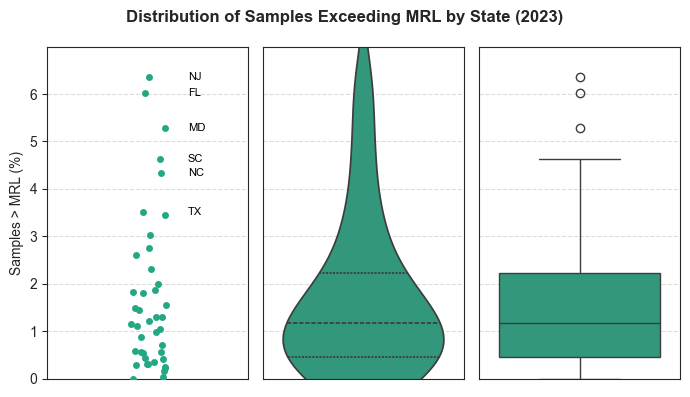

In [273]:
"""Visualization: Strip, violin, bar plots of mean relative contamination (2023)"""

# Set general plot style
sns.set_style("ticks")

# Create a single-row, three-column figure layout
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

# Global y-axis limits
y_min = 0
y_max = df_states["Equals_Per_Total"].max() * 1.1


# Identify top 3 and bottom 3 states by Mean Relative Contamination
top_3 = df_states.nlargest(6, "Equals_Per_Total")
bottom_3 = df_states.nsmallest(0, "Equals_Per_Total")
highlight_states = pd.concat([top_3, bottom_3])


# Strip plot for Mean Relative Contamination
main_color = sns.color_palette("viridis", as_cmap=True)(0.6)
sns.stripplot(y=df_states["Equals_Per_Total"], ax=axes[0], jitter=True, color=main_color)

for i, row in highlight_states.iterrows():
    axes[0].text(0.2, row["Equals_Per_Total"], row["State"],  # Shifted x-position
                 ha="left", va="center", fontsize=8, color="black")


axes[0].set_ylabel("Samples > MRL (%)")

# Violin plot for Mean Relative Contamination
sns.violinplot(y=df_states["Equals_Per_Total"], ax=axes[1], inner="quartile", color=main_color)
axes[1].set_ylabel("")
axes[1].set_yticklabels([])  
axes[1].tick_params(left=False)  

# Box plot for Mean Relative Contamination
sns.boxplot(y=df_states["Equals_Per_Total"], ax=axes[2], color=main_color)
axes[2].set_ylabel("")
axes[2].set_yticklabels([])  
axes[2].tick_params(left=False)  

# Set same y-axis range for all subplots and add horizontal gridlines
for ax in axes:
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_ylim(y_min, y_max)  
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)  

fig.suptitle("Distribution of Samples Exceeding MRL by State (2023)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

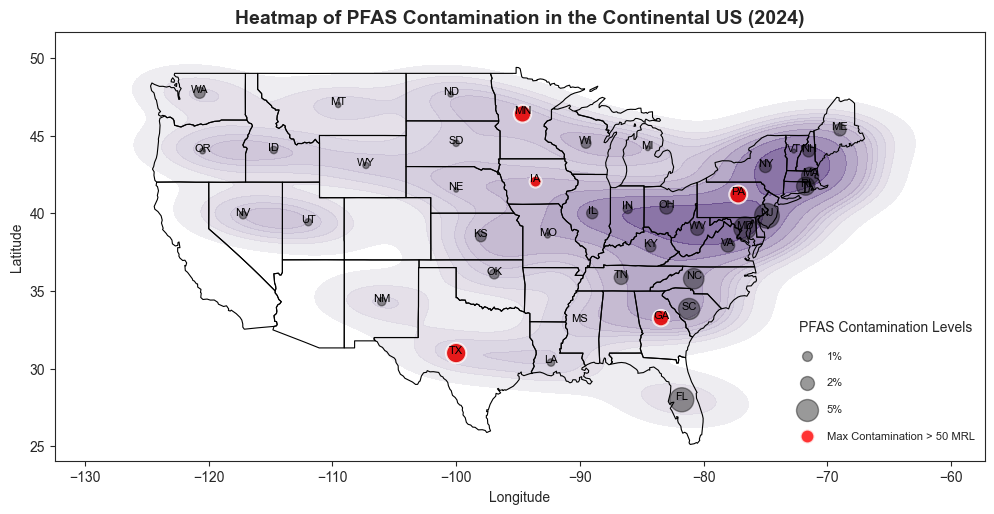

In [29]:
"""Visualization: Create heat map of PFAS contamination -- Percentage of Samples Exceeding MRL by State (2024)"""

# Filter df_states to include only continental U.S. states
non_continental_fips = ["02", "15", "72"] # Alaska, Hawaii, PRico

# Load US states borders from GeoJSON
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(url)
usa_continental = usa[~usa["id"].isin(non_continental_fips)] # FIlter out non-continental states

df_states_cont = df_states[~df_states["State"].isin(["HI", "PR", "DC","AK"])]

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

usa_continental.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Create the heatmap
blue_tone = sns.color_palette("viridis", as_cmap=True)(0.1)  

sns.kdeplot(
    data=df_states_cont,
    x="Longitude",
    y="Latitude",
    cmap= sns.light_palette(blue_tone, as_cmap=True),
    fill=True,
    bw_adjust=0.5,
    alpha=0.7,
    thresh=0.05,
    ax=ax
)

# Define scaling for legend
scale_factor = 5000  # Match the scatter size scaling
sizes = [ 0.01, 0.02, 0.05]  # Example PFAS detection levels
legend_labels = [f"{s*100:.00f}%" for s in sizes]

# Overlay PFAS contamination points
plt.scatter(
    df_states_cont["Longitude"],
    df_states_cont["Latitude"],
    s=df_states_cont["Equals_Per_Total"] * 5000,  # Scale based on detections
    color="black",
    alpha=0.4
)

# Highlight states where Max_Relative_Contamination > 50
high_contamination = df_states_cont[df_states_cont["Max_Relative_Contamination"] > 50]

plt.scatter(
    high_contamination["Longitude"],
    high_contamination["Latitude"],
    s=high_contamination["Equals_Per_Total"] * scale_factor * 1.2,  # Slightly bigger size
    color="red",
    edgecolor="white",
    linewidth=1.5,
    alpha=0.8,
    label="Max Contamination > 50"
)

# Add state labels
for _, row in df_states_cont.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["State"], fontsize=8, ha="center", color="black")

# Create a custom legend for scatter sizes
legend_handles = [
    plt.scatter([], [], s=s * scale_factor, color="black", alpha=0.4, label=label)
    for s, label in zip(sizes, legend_labels)
]


# Add the high-contamination legend entry
legend_handles.append(
    plt.scatter([], [], s=100, color="red", edgecolor="white", linewidth=1.5, alpha=0.8, label="Max Contamination > 50 MRL")
)
# Add the legend
ax.legend(handles=legend_handles, title="PFAS Contamination Levels", bbox_to_anchor=(1, 0.35), fontsize=8, frameon=False,labelspacing=1.5 )

# Set labels and title
plt.title("Heatmap of PFAS Contamination in the Continental US (2024)", fontsize=14, fontweight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


/var/folders/zn/2ym95l4n2131dptxjp4dk3fh0000gn/T/ipykernel_99115/1168526345.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


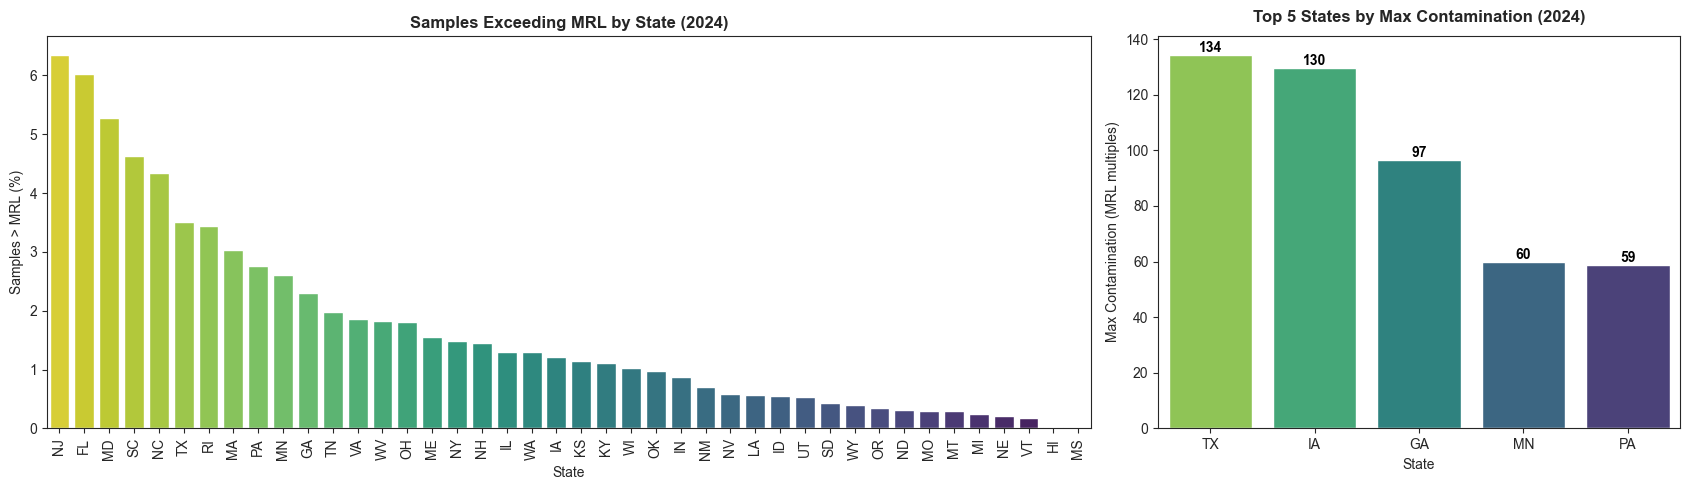

In [ ]:


# Create a single figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

# Convert y-axis to percentage and sort by value
df_sorted = df_states.sort_values(by="Equals_Per_Total", ascending=False).copy()

# Plot 1: Percentage of Samples Exceeding MRL by State
sns.barplot(
    data=df_sorted,
    x="State",
    y=df_sorted["Equals_Per_Total"] * 100, 
    palette="viridis_r",
    hue="State",
    legend=False,
    ax=axes[0]
)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title("Samples Exceeding MRL by State (2023)", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Samples > MRL (%)", fontsize=10)
axes[0].set_xlabel("State", fontsize=10)

# Plot 2: Top 5 States by Max Relative PFAS Contamination
top5_states = df_states.nlargest(5, "Max_Relative_Contamination").copy()
ax2 = sns.barplot(
    data=top5_states,
    x="State",
    y="Max_Relative_Contamination",
    palette="viridis_r",
    legend=False,
    hue="State",
    ax=axes[1]
)

# Annotate values on bars
for p in ax2.patches:
    ax2.annotate(
        f"{p.get_height():.0f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10, 
        fontweight="bold",
        color="black"
    )

axes[1].set_title("Top 5 States by Max Contamination (2023)", fontsize=12, fontweight="bold", pad=10)
axes[1].set_xlabel("State", fontsize=10)
axes[1].set_ylabel("Max Contamination (MRL multiples)", fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

,Year,Total_Values,Count_Less_Than,Count_Equals,Max_Relative_Contamination,Mean_Relative_Contamination,Equals_Per_Total,Max_Relative_Contamination_N,Mean_Relative_Contamination_N,Equals_Per_Total_N
0,2014,1536,1373,163,32.5,4.378408,10.611979,1.000000,1.000000,1.000000
1,2024,10743,10586,157,30.5,2.106348,1.461417,0.938462,0.481076,0.137714


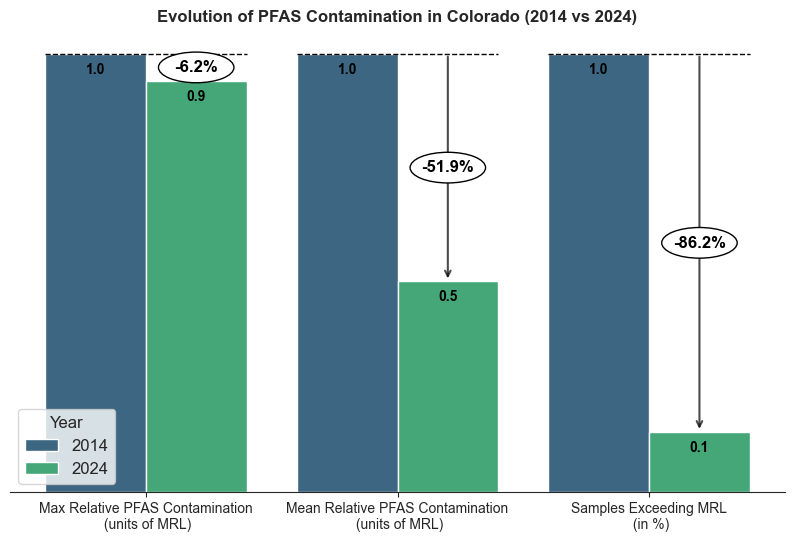

In [252]:
"""Visualization: Plot PFAS contamination levels (samples exceeding MRL) for COLORADO over time"""

# FIlter for Colorado
df_CO = df[df["State"] == "CO"]

# Filter for 2014 and 2024
df_CO_2014_2024 = df_CO[(df_CO["Year"] == 2014) | (df_CO["Year"] == 2024)]

# Aggregate data per year
df_years = df_CO_2014_2024.groupby("Year").agg(
    Total_Values=('Total_Values', 'sum'),
    Count_Less_Than=('Count_Less_Than', 'sum'),
    Count_Equals=('Count_Equals', 'sum'),
    Max_Relative_Contamination=('Relative_Contamination_Level', 'max')
).reset_index()

df_mean = df_CO_2014_2024[df_CO_2014_2024["Count_Equals"] == 1].groupby("Year")["Relative_Contamination_Level"].mean().reset_index()
df_mean.rename(columns={"Relative_Contamination_Level": "Mean_Relative_Contamination"}, inplace=True)

# ✅ Corrected merge
df_years = df_years.merge(df_mean, on="Year", how="left")



# Add a relative column, contaminated samples / all samples
df_years["Equals_Per_Total"] = df_years['Count_Equals'] / df_years['Total_Values'] * 100

# Add normalized values for plotting
max_relative_cont_2014 = df_years.loc[df_years["Year"] == 2014, "Max_Relative_Contamination"].values[0]
mean_relative_cont_2014 = df_years.loc[df_years["Year"] == 2014, "Mean_Relative_Contamination"].values[0]
equals_per_total_2014 = df_years.loc[df_years["Year"] == 2014, "Equals_Per_Total"].values[0] 


df_years["Max_Relative_Contamination_N"] = df_years["Max_Relative_Contamination"] / max_relative_cont_2014
df_years["Mean_Relative_Contamination_N"] = df_years["Mean_Relative_Contamination"] / mean_relative_cont_2014
df_years["Equals_Per_Total_N"] = df_years["Equals_Per_Total"] / equals_per_total_2014 


# Display the aggregated DataFrame
display(df_years)


"""Create the bar comparison plot"""

df_years["Max Relative PFAS Contamination\n (units of MRL)"] = df_years["Max_Relative_Contamination_N"]
df_years["Mean Relative PFAS Contamination\n (units of MRL)"] = df_years["Mean_Relative_Contamination_N"]
df_years["Samples Exceeding MRL\n (in %)"] = df_years["Equals_Per_Total_N"]

# Define the normalized metrics for plotting
normalized_metrics = ["Max Relative PFAS Contamination\n (units of MRL)", "Mean Relative PFAS Contamination\n (units of MRL)", "Samples Exceeding MRL\n (in %)"]

# Melt the DataFrame for seaborn
df_melted = df_years.melt(id_vars=["Year"], value_vars=normalized_metrics, var_name="Metric", value_name="Value")

# Create the seaborn bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x="Metric", y="Value", hue=df_melted["Year"].astype(str), palette="viridis")

# Convert df_years into a pivot table for easier lookup
df_pivot_norm = df_years.set_index("Year")[normalized_metrics].T  # Normalized values for plotting
df_pivot_orig = df_years.set_index("Year")[normalized_metrics].T  # Non-normalized values for annotations
df_pivot_norm["Percent_Change"] = ((df_pivot_norm[2024] - df_pivot_norm[2014]) / df_pivot_norm[2014]) * 100  # Compute % change

# Add value labels, arrows, and percentage change annotations
for i, (norm_metric, orig_metric) in enumerate(zip(normalized_metrics, normalized_metrics)):
    values_norm = df_pivot_norm.loc[norm_metric, [2014, 2024]].values  # Normalized values for bar heights
    values_orig = df_pivot_orig.loc[orig_metric, [2014, 2024]].values  # Non-normalized values for annotations
    percent_change = df_pivot_norm.loc[norm_metric, "Percent_Change"]  # Percentage change

    # Find x positions of bars for annotation
    bar1 = ax.patches[i]  # First bar (2014)
    bar2 = ax.patches[i + len(normalized_metrics)]  # Second bar (2024)
    
    # Add non-normalized value labels on top of bars
    # Adjust text position to be inside the bar at the top
    ax.annotate(f"{values_orig[0]:.1f}", 
                (bar1.get_x() + bar1.get_width() / 2, bar1.get_height() - 0.02),  # Move text inside the bar
                ha='center', va='top', fontsize=10, fontweight="bold", color="black")

    ax.annotate(f"{values_orig[1]:.1f}", 
                (bar2.get_x() + bar2.get_width() / 2, bar2.get_height() - 0.02),  # Move text inside the bar
                ha='center', va='top', fontsize=10, fontweight="bold", color="black")


    # Calculate arrow position
    x_start = bar1.get_x() + bar1.get_width() * 1.5  # Middle of first bar
    x_end = bar2.get_x() + bar2.get_width() / 2  # Middle of second bar
    y_start = bar1.get_height() * 1.0  # Slightly above first bar
    y_end = bar2.get_height() + 0.00  # Slightly above second bar

    # Draw an arrow **in the background** (before ellipses and text)
    ax.annotate("", xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="black", alpha=0.7), zorder=1)

    # Calculate position for the percentage annotation
    mid_x = (x_start + x_end) / 2  # Midpoint between bars
    mid_y = (y_start + y_end) / 2  # Midpoint along the arrow

    # Draw an ellipse (oval) **on top of the arrow**
    ellipse = patches.Ellipse((mid_x, mid_y), width=0.3, height=0.07, 
                              edgecolor="black", facecolor="white", linewidth=1, zorder=2)
    ax.add_patch(ellipse)

    # Add percentage change text **on top of the ellipse**
    ax.annotate(f"{percent_change:.1f}%", (mid_x, mid_y), 
                ha='center', va='center', fontsize=12, fontweight="bold", color="black", zorder=3)

    # Add a thin black dashed line on top of the first bar and extend it to the second bar
    ax.plot([bar1.get_x(), bar2.get_x() + bar2.get_width()], 
            [y_start, y_start], color="black", linewidth=1, linestyle="dashed", zorder=1)

# Customize labels and title
plt.xlabel("")
plt.ylabel("Normalized Value")
ax.get_yaxis().set_visible(False)  # Hides the y-axis completely

plt.title("Evolution of PFAS Contamination in Colorado (2014 vs 2024)", fontweight="bold")
sns.despine(left=True, right=True, top=True, bottom=False)  # Removes borders

# Get x-tick positions and labels from the seaborn bar plot
xticks_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]  # X-axis tick positions
#xtick_labels = original_metrics  # Use original metrics for annotatio

plt.legend(title="Year", title_fontsize=12, fontsize=12)  # Increase title & text size

plt.show()



In [ ]:
"""Data preprocessing: Create seperate data frames for 2023, Aggregation per COUNTY"""



df["CollectionDate"] = pd.to_datetime(df["CollectionDate"], errors='coerce')

df.loc[:, "Total_Values"] = df_PFAS["Count_Less_Than"] + df_PFAS["Count_Equals"]


# Create seperate file for 2023 data only
df_2023 = df[df["CollectionDate"].dt.year == 2023].copy()


# Aggregate data per state
df_counties = df_2023.groupby("County").agg(
    State=('State', lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]), 
    Total_Values=('Total_Values', 'sum'),
    Count_Less_Than=('Count_Less_Than', 'sum'),
    Count_Equals=('Count_Equals', 'sum'),
    Max_Relative_Contamination=('Relative_Contamination_Level', 'max'),
    Median_Income = ('Median_Income', 'max'),
    Poverty_Rate = ('Poverty_Rate', 'max')
).reset_index()

# Compute Mean_Relative_Contamination where Count_Equals == 1
df_mean = df_2023[df_2023["Count_Equals"] == 1].groupby("County")["Relative_Contamination_Level"].mean().reset_index()
df_mean.rename(columns={"Relative_Contamination_Level": "Mean_Relative_Contamination"}, inplace=True)


# Merge back the Mean_Relative_Contamination values
df_counties = df_counties.merge(df_mean, on="County", how="left")
df_counties["Mean_Relative_Contamination"] = df_counties["Mean_Relative_Contamination"].fillna(0)

# Remove non-state territories (i.e. numbers instead of states in state col)
df_counties = df_counties.iloc[8:].reset_index(drop=True)

# Add col for contaminated samples: "samples exceeding MRL" / "total samples"
df_counties["Equals_Per_Total"] = df_counties["Count_Equals"] / df_counties["Total_Values"] *100
df_counties.insert(4, "Equals_Per_Total", df_counties.pop("Equals_Per_Total"))

# Merge df_counties with state_abbreviations to add full state names
df_counties = pd.merge(df_counties, state_abbreviations, on="State", how="left")

# Move "State_long" (full state name) to the second column position
df_counties.insert(1, "State_long", df_counties.pop("State_long"))

# Sort by "Equals_Per_Total" in descending order
df_counties = df_counties.sort_values(by="Equals_Per_Total", ascending=False)


state_abbreviations = pd.DataFrame({
    'State_long': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
              'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
              'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
              'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
              'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
    'State': ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                     'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                     'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                     'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                     'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
})



# Load county coordinates dataset
df_county_coords = pd.read_csv("uscounties.csv")

# Rename columns to match df_counties
df_county_coords.rename(columns={"state_name": "State_long", "county_full": "County", "lat": "Latitude", "lng": "Longitude"}, inplace=True)

# Convert state names to lowercase
df_county_coords["State_long"] = df_county_coords["State_long"].str.lower()
df_counties["State_long"] = df_counties["State_long"].str.lower()

# Merge with df_counties
df_counties = pd.merge(df_counties, df_county_coords[["State_long", "County", "Latitude", "Longitude"]], on=["State_long","County"], how="left")

# Move "Latitude" and "Longitude" to second and third position
df_counties.insert(1, "Latitude", df_counties.pop("Latitude"))
df_counties.insert(2, "Longitude", df_counties.pop("Longitude"))

# Display updated dataframe
df_counties.head(10)

df_counties.head(10)  # This will print the table output in Jupyter Notebook


,County,Latitude,Longitude,State_long,State,Total_Values,Count_Less_Than,Equals_Per_Total,Count_Equals,Max_Relative_Contamination,Median_Income,Poverty_Rate,Mean_Relative_Contamination
0,Harnett County,35.3689,-78.8693,north carolina,NC,153,113,26.143791,40,7.466667,70074.0,13.7,2.524083
1,Gordon County,34.5032,-84.8759,georgia,GA,116,89,23.275862,27,96.666667,64795.0,12.9,8.893148
2,Miami-Dade County,25.6150,-80.5624,florida,FL,522,405,22.413793,117,38.000000,72030.0,14.1,4.425456
3,Prince William County,38.7029,-77.4809,virginia,VA,58,45,22.413793,13,7.300000,128758.0,6.7,3.420897
4,Guilford County,36.0795,-79.7889,north carolina,NC,464,362,21.982759,102,8.900000,65890.0,14.8,2.161225
5,Laurens County,34.4834,-82.0057,south carolina,SC,116,93,19.827586,23,13.300000,56237.0,16.7,3.301812
6,New Castle County,39.5768,-75.6527,delaware,DE,472,379,19.703390,93,40.966667,86798.0,10.9,4.682007
7,Brunswick County,34.0715,-78.2383,north carolina,NC,178,143,19.662921,35,4.000000,76797.0,10.3,1.978333
8,Dorchester County,33.0794,-80.4068,south carolina,SC,120,97,19.166667,23,2.233333,78329.0,10.2,1.438623
9,Clayton County,33.5420,-84.3576,georgia,GA,348,282,18.965517,66,6.000000,57974.0,17.3,2.072980


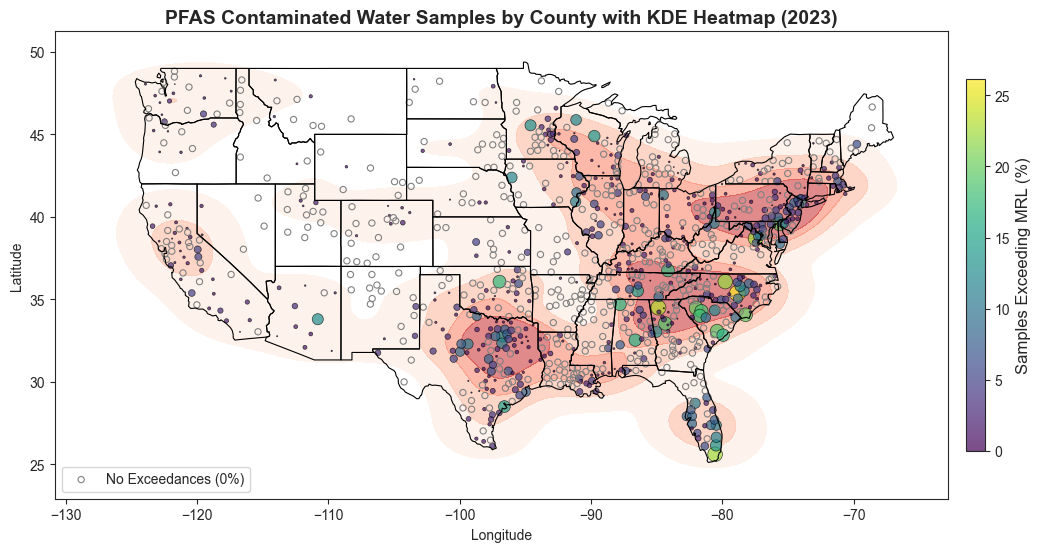

In [279]:
"""County Heatmap"""

# Filter df_states to include only continental U.S. states
non_continental_fips = ["02", "15", "72"]  # Alaska, Hawaii, Puerto Rico

# Load US states borders from GeoJSON
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(url)
usa_continental = usa[~usa["id"].isin(non_continental_fips)]  # Filter out non-continental states

df_states_cont = df_counties[~df_counties["State"].isin(["HI", "PR", "DC", "AK"])]

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot state boundaries
usa_continental.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Normalize Equals_Per_Total for colormap (use viridis)
norm = plt.Normalize(df_states_cont["Equals_Per_Total"].min(), df_states_cont["Equals_Per_Total"].max())
cmap = plt.cm.viridis

# KDE Heatmap for contaminated points only
sns.kdeplot(
    x=df_states_cont[df_states_cont["Equals_Per_Total"] > 0]["Longitude"],
    y=df_states_cont[df_states_cont["Equals_Per_Total"] > 0]["Latitude"],
    cmap="Reds",  # Heatmap in red shades
    fill=True,
    bw_adjust=0.5,
    alpha=0.5,
    levels=5,
    thresh=0.05,
    ax=ax
)

# Scatter plot for non-zero contamination points
sc = ax.scatter(
    df_states_cont[df_states_cont["Equals_Per_Total"] > 0]["Longitude"],
    df_states_cont[df_states_cont["Equals_Per_Total"] > 0]["Latitude"],
    s=df_states_cont[df_states_cont["Equals_Per_Total"] > 0]["Equals_Per_Total"] * 5,  # Scale size
    c=df_states_cont[df_states_cont["Equals_Per_Total"] > 0]["Equals_Per_Total"],  # Color by contamination
    cmap=cmap,
    norm=norm,
    alpha=0.7,
    edgecolors="black",
    linewidth=0.5
)

# Scatter plot for zero contamination points (empty circles)
ax.scatter(
    df_states_cont[df_states_cont["Equals_Per_Total"] == 0]["Longitude"],
    df_states_cont[df_states_cont["Equals_Per_Total"] == 0]["Latitude"],
    s=20,  # Fixed size for zero values
    facecolors="none",  # Empty circles
    edgecolors="gray",  # Gray outline
    linewidth=0.8,
    label="No Exceedances (0%)"
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.02)
cbar.set_label("Samples Exceeding MRL (%)", fontsize=12)

# Set labels and title
plt.title("PFAS Contaminated Water Samples by County with KDE Heatmap (2023)", fontsize=14, fontweight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add legend for zero values
plt.legend(loc="lower left")

# Show plot
plt.show()

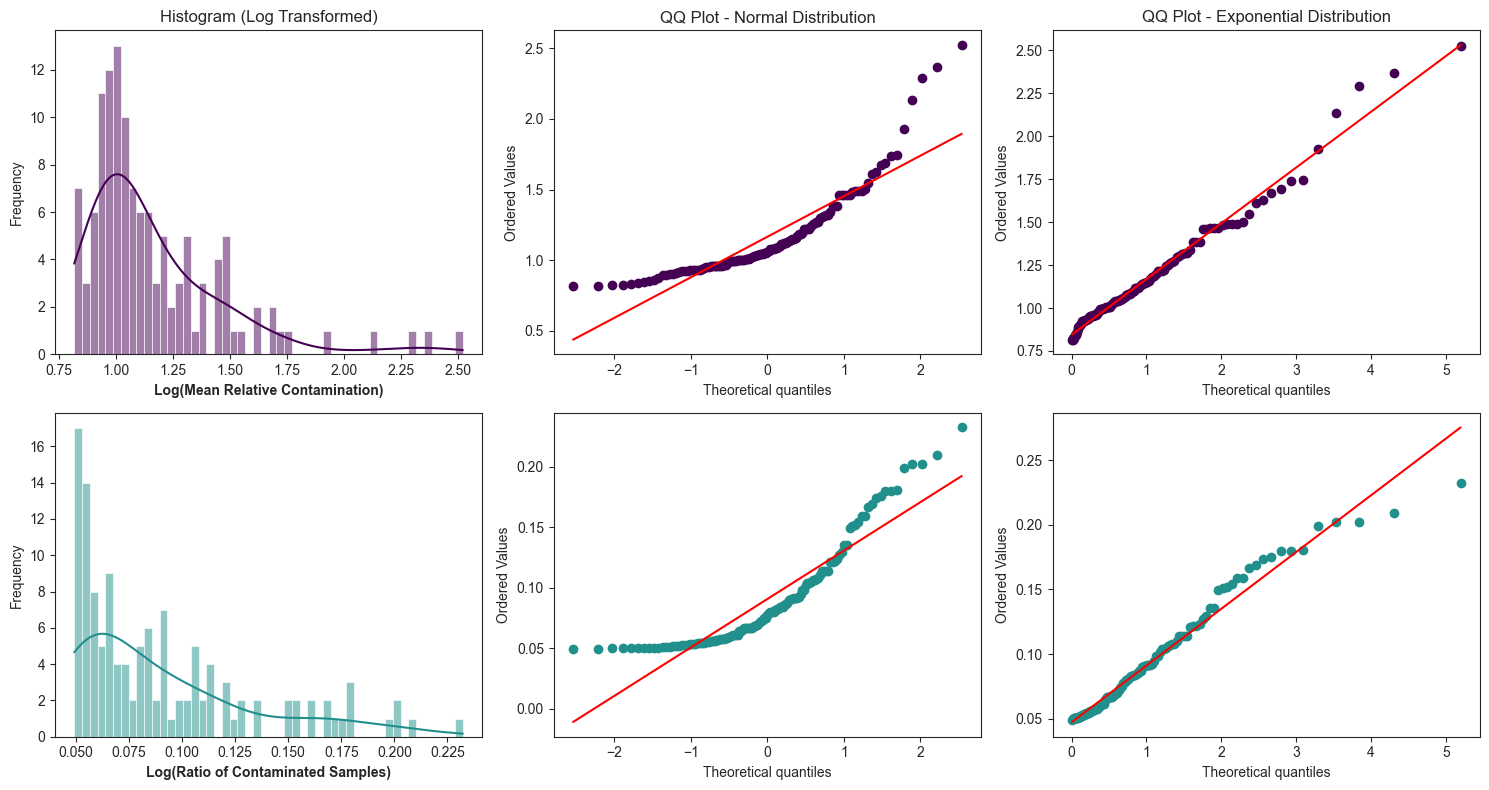

In [233]:
"""Histograms and qq plots"""

# Remove zero values to avoid log(0) issues
df_filtered = df_counties[df_counties["Equals_Per_Total"] != 0]


# Apply log transformation
data_log_mean = np.log1p(df_filtered["Mean_Relative_Contamination"])
data_log_equals = np.log1p(df_filtered["Equals_Per_Total"]/100)

# Define clearly different colors for histograms
colors = ["#440154", "#21908C"]  # Purple and Teal from viridis

# Create a two-row, three-column figure layout
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Row 1: Mean Relative Contamination
sns.histplot(data_log_mean, bins=50, kde=True, color=colors[0], ax=axes[0, 0])
axes[0, 0].set_xlabel("Log(Mean Relative Contamination)", fontweight="bold")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Histogram (Log Transformed)")

stats.probplot(data_log_mean, dist="norm", plot=axes[0, 1])
axes[0, 1].get_lines()[0].set_color(colors[0])  # Adjust QQ plot data points color
axes[0, 1].get_lines()[1].set_color("red")  # Keep the fit line red
axes[0, 1].set_title("QQ Plot - Normal Distribution")

stats.probplot(data_log_mean, dist="expon", plot=axes[0, 2])
axes[0, 2].get_lines()[0].set_color(colors[0])  # Adjust QQ plot data points color
axes[0, 2].get_lines()[1].set_color("red")  # Keep the fit line red
axes[0, 2].set_title("QQ Plot - Exponential Distribution")

# Row 2: Equals_Per_Total
sns.histplot(data_log_equals, bins=50, kde=True, color=colors[1], ax=axes[1, 0])
axes[1, 0].set_xlabel("Log(Ratio of Contaminated Samples)", fontweight="bold")
axes[1, 0].set_ylabel("Frequency")

stats.probplot(data_log_equals, dist="norm", plot=axes[1, 1])
axes[1, 1].get_lines()[0].set_color(colors[1])  # Adjust QQ plot data points color
axes[1, 1].get_lines()[1].set_color("red")  # Keep the fit line red

stats.probplot(data_log_equals, dist="expon", plot=axes[1, 2])
axes[1, 2].get_lines()[0].set_color(colors[1])  # Adjust QQ plot data points color
axes[1, 2].get_lines()[1].set_color("red")  # Keep the fit line red

# Remove titles for second row
for ax in axes[1, :]:
    ax.set_title("")

plt.tight_layout()
plt.show()

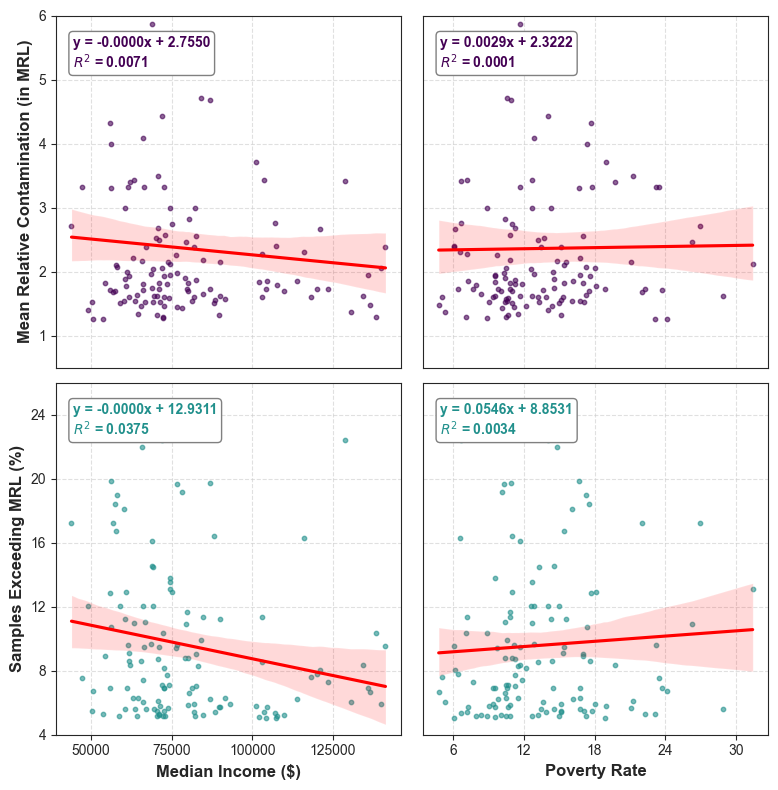

In [ ]:
"""Correlation Contamination vs Poverty Data"""

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df_counties = df_counties[df_counties["Equals_Per_Total"] > 5]

# Drop NaN values to avoid issues
df_filtered = df_counties.dropna(subset=["Median_Income", "Poverty_Rate", 
                                         "Mean_Relative_Contamination", 
                                         "Equals_Per_Total"])

# Cap Mean Relative Contamination at 8
df_filtered["Mean_Relative_Contamination"] = df_filtered["Mean_Relative_Contamination"].clip(upper=8)

# Define function to add R² and regression line equation
def add_regression_text(ax, x, y, color):
    x_vals = df_filtered[x].values.reshape(-1, 1)
    y_vals = df_filtered[y].values
    model = LinearRegression().fit(x_vals, y_vals)
    r2 = r2_score(y_vals, model.predict(x_vals))
    
    equation = f"y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}\n$R^2$ = {r2:.4f}"
    
    ax.text(0.05, 0.85, equation, transform=ax.transAxes, 
            fontsize=10, color=color, fontweight="bold",
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# Create a two-column figure layout
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Colors for consistency per row
color_mean = "darkblue"  # Color for Median Income plots
color_equals = "darkgreen"  # Color for Poverty Rate plots

# Plot 1: Median Income vs Mean Relative Contamination
sns.regplot(data=df_filtered, x="Median_Income", y="Mean_Relative_Contamination", 
            scatter_kws={'color': colors[0], 'alpha': 0.6, 's': 10}, 
            line_kws={'color': 'red'}, ax=axes[0, 0])

axes[0, 0].set_xlabel("Median Income", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("Mean Relative Contamination (in MRL)", fontsize=12, fontweight="bold")
axes[0, 0].set_title("Median Income vs Mean Relative Contamination", fontsize=12, fontweight="bold")
add_regression_text(axes[0, 0], "Median_Income", "Mean_Relative_Contamination", colors[0])

# Plot 2: Median Income vs Percentage of Contaminated Samples
sns.regplot(data=df_filtered, x="Median_Income", y="Equals_Per_Total", 
            scatter_kws={'color': colors[1], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[1, 0])

axes[1, 0].set_xlabel("Median Income ($)", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Samples Exceeding MRL (%)", fontsize=12, fontweight="bold")
axes[1, 0].set_title("Median Income vs Contaminated Samples", fontsize=12, fontweight="bold")
add_regression_text(axes[1, 0], "Median_Income", "Equals_Per_Total", colors[1])

# Plot 3: Poverty Rate vs Mean Relative Contamination
sns.regplot(data=df_filtered, x="Poverty_Rate", y="Mean_Relative_Contamination", 
            scatter_kws={'color': colors[0], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[0, 1])

axes[0, 1].set_xlabel("Poverty Rate", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("Mean Relative Contamination", fontsize=12, fontweight="bold")
axes[0, 1].set_title("Poverty Rate vs Mean Relative Contamination", fontsize=12, fontweight="bold")
add_regression_text(axes[0, 1], "Poverty_Rate", "Mean_Relative_Contamination", colors[0])

# Plot 4: Poverty Rate vs Percentage of Contaminated Samples
sns.regplot(data=df_filtered, x="Poverty_Rate", y="Equals_Per_Total", 
            scatter_kws={'color': colors[1], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[1, 1])

axes[1, 1].set_xlabel("Poverty Rate", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Percentage Contaminated Samples", fontsize=12, fontweight="bold")
axes[1, 1].set_title("Poverty Rate vs Contaminated Samples", fontsize=12, fontweight="bold")
add_regression_text(axes[1, 1], "Poverty_Rate", "Equals_Per_Total", colors[1])

# Remove all titles
for ax in axes.flat:
    ax.set_title("")

# Remove x-labels for plots 1 (top-left) and 2 (top-right)
axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")

# Remove y-axis labels and ticks for plots 2 (top-right) and 4 (bottom-right)
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")
axes[0, 1].set_yticks([])  # Remove y-axis numbers
axes[1, 1].set_yticks([])  # Remove y-axis numbers
axes[0, 1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axes[0, 0].tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)

axes[1, 1].tick_params(left=False,labelleft=False)



# Set y-axis limit for plots 1 and 2 (first row)
axes[0, 0].set_ylim(0.5, 6)  # Limit y-axis for Plot 1
axes[0, 1].set_ylim(0.5, 6)  # Limit y-axis for Plot 2

axes[1, 0].set_ylim(4, 26)  # Limit y-axis for Plot 1
axes[1, 1].set_ylim(4, 26)  # Limit y-axis for Plot 2

# Adjust layout
plt.tight_layout()

import matplotlib.ticker as mticker

# Loop through all subplots and enable gridlines
for ax in axes.flatten():
    ax.grid(True, linestyle="--", alpha=0.6)  # Dashed gridlines globally

# Ensure consistent grid spacing
for ax in axes.flatten():
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))  # Set same number of y-axis ticks
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))  # Set same number of x-axis ticks

# Manually adjust y-axis for plots 2 and 4
for ax in [axes[0, 1], axes[1, 1]]:
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)  # Ensure gridlines appear






plt.show()